# 混合指数分布を実装する

### インポートモジュール

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

## 1.まず指数分布について

### 指数分布のクラスを作る

指数分布の確率密度関数は、
$$
f(x) = \lambda exp(-\lambda x)
$$

であり、N個のサンプルの対数尤度関数は、
$$
\begin{align}
l(\lambda|x) &= \sum_{i = 1}^{N}\log(\lambda \exp(-\lambda x_i)) \\
&=n\log\lambda - \lambda \sum_{i = 1}^{N}x_j
\end{align}
$$

よって最尤推定量は、
$$
\hat{\lambda}^{MLE} = \frac{N}{\sum_{i = 1}^{N}x_i}
$$

In [3]:
class ExpDistribution:
    def __init__(self,param_la):
        self.param_la = param_la
    
    # DensityFunction
    def PDF(self,x):
        return self.param_la * np.exp(-1 * self.param_la * x)
    
    # MaximumLikelihoodEstimation
    def MLEfit(self,x):
        self.param_la = len(x) / np.sum(x)
        return self.param_la

## 2.ポアソン過程をシミュレーションしてみる

一定確率で起こるイベントが、発生するまでの時間をシミュレーションする。
ただし、観測の右側打ち切りは無いものとする。

In [4]:
# 確率一定でランダムに起きる事象をシミュレーション
def rand_event(size_N = 5000,event_p = 0.05):
    x = np.zeros(size_N)
    j = 0
    # 今回は観測打ち切りはない
    #for j in range(int(1/event_p) *100):
    while np.any(x == 0):
        j += 1
        # 遅いのでnumpy使う
#         for i in range(size):
#             if (np.random.binomial(n = 1,p = event_p) == 1) & (x[i] == 0):
#                 x[i] = j
        y = np.random.binomial(n = 1,p = event_p,size = size_N)*j
    
        x = np.where((y != 0) & (x ==0),y,x)

    return x

In [5]:
np.random.seed(0)
x = rand_event(size_N = 100000,event_p=0.05)

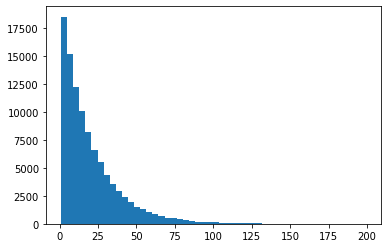

In [6]:
plt.hist(x,bins = 50)
plt.show()

## 指数分布とポアソン過程を比べる

In [7]:
# 連続した整数
y = np.arange(np.max(x))
Exp_object = ExpDistribution(param_la=0.1)

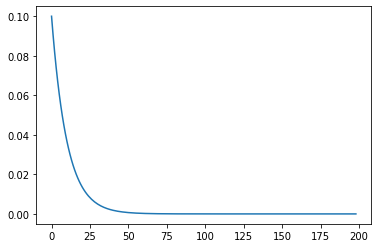

In [8]:
plt.plot(Exp_object.PDF(y))

$\lambda = 1$の指数分布

# シミュレートしたデータに対して、指数分布をfitting

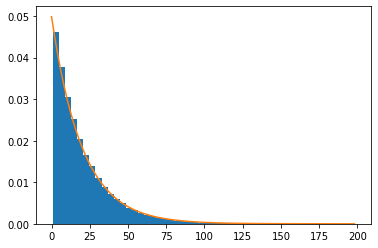

In [25]:
# パラメーターを最尤推定値で更新
weights = np.ones(len(x))/float(len(x))
Exp_object.MLEfit(x)
plt.hist(x,bins = 50,weights = weights/4)
plt.plot(Exp_object.PDF(y))
#plt.hist(x,bins = 50,normed = True)
plt.show()

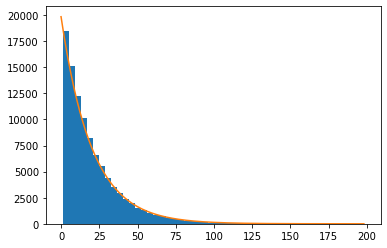

In [9]:
size_N = 100000
bins_num = 50
dt = np.max(x) / bins_num
plt.hist(x,bins = bins_num)
plt.plot(Exp_object.PDF(y) * size_N *dt)
plt.show()

フィットしている

# 2.混合指数モデル

## 利点

あるイベント(ポアソン過程に従う)についての発生確率が異なる集団に対して、一つの確率分布で表現できる。<br>
イベントが発生するまでの時間に関してのデータのみが観測できたとき、そのデータを使って、クラスタを特定(ただし、確率的)できる。

## 初期状態

In [13]:
K = 2
sample_size_1 = 200000
sample_size_2 = 100000

In [36]:
np.random.seed(0)
time_1 = rand_event(size_N = sample_size_1,event_p=0.05)
time_2 = rand_event(size_N = sample_size_2,event_p=0.2)
time_1and2 = np.hstack((time_1,time_2))

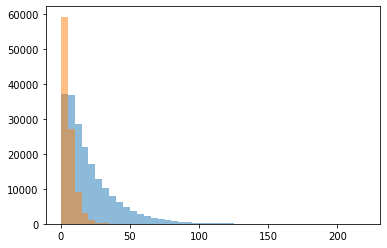

In [50]:
max_time_1and2 = np.max(time_1and2).astype(int)
bins_1and2 = range(0,max_time_1and2,5)

#plt.hist((time_1,time_2),bins = 100)
plt.hist(time_1,bins = bins_1and2,alpha = 0.5)
plt.hist(time_2,bins = bins_1and2,alpha = 0.5)
plt.show()

どちらのクラスかわからずに観測されている場合は、下図のようになる。

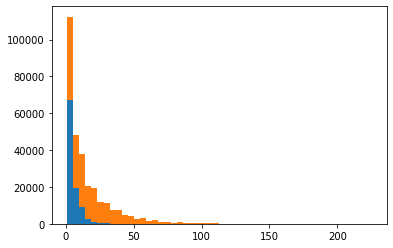

In [26]:
plt.hist((time_2,time_1),stacked = True,bins = 50)
plt.show()

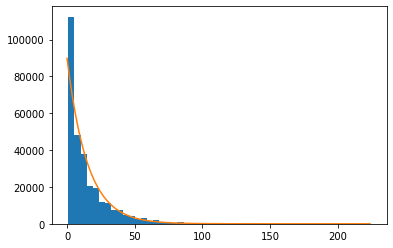

In [51]:
# パラメーターを最尤推定値で更新
Exp_object.MLEfit(time_1and2)
#plt.plot(Exp_object.PDF(y)*1000)
size_N = sample_size_1 + sample_size_2
bins_num = 50
dt = np.max(time_1and2) / bins_num
x_dist = np.arange(np.max(time_1and2))

plt.hist(time_1and2,bins = bins_num)
plt.plot(Exp_object.PDF(x_dist) * size_N *dt)
plt.show()

この場合、うまくフィットできていない

## 本題:混合指数分布について

### 確率密度関数

$\lambda = (\lambda_1,\lambda_2,\cdots,\lambda_k)$ , $\lambda_i > 0$,<br>
$\pi = (\pi_1,\pi_2,\cdots,\pi_k)$ , $0<\pi_i<1$ , $\sum_{k = 1}^{K}\pi_k = 1 $を満たすとする。<br>
pdfは、
$$
f(x|\pi,\lambda) = \sum_{k = 1}^{K}\pi_k \lambda_k exp(-\lambda_k x)
$$



### 混合指数分布の最尤推定

最適化問題は、
$$
\min_{\lambda,\pi} \left[-\sum_{n=1}^{N}\log{\sum_{k = 1}^{K}\pi_k \lambda_k exp(-\lambda_k x)}\right]　\\
s.t. \sum_{k = 0}^{K}\pi_{k} = 1
$$
nktmemoja.github.io/jekyll/update/2017/03/19/time-series-analysis.html
によると、最適化問題を変形できる。まず、

$$
\max_{Q}\left[
\sum_{n = 1}^{N}\sum_{k = 1}^{K}Q_{nk}(\log{\pi_k} + 
\log{\lambda_k} -\lambda_k x -\log{Q_{nk}})
\right]\\
s.t. \sum_{k = 1}^{K}Q_{nk} = 1
$$

これを解き、
$$
Q_{nk} = \frac{\pi_k\lambda_k\exp(-\lambda_k x)}
{\sum_{k'= 1}^{K}\pi_{k'}\lambda_{k'}\exp(-\lambda_{k'}x)}
$$